# Model 1: Logistic Regression

1. Logistic Regression
2. Random Forest? AdaBoost?
3. CNN? RNN?

In [1]:
from dotenv import load_dotenv
import sys
import warnings

from __init__ import get_base_path
import data.load_data as load_data
import models.model_utils as models

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, TargetEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

load_dotenv()
warnings.filterwarnings('ignore')

/Users/kaimazurczyk/Desktop/power-grid-time-series-classification


In [2]:
random_seed = int(os.getenv('RANDOM_SEED'))
random_seed

42

In [3]:
csv_file = load_data.combined_csv

if os.path.exists(csv_file):
    pass
else:
    load_data.__main__()
df = pd.read_csv(csv_file,index_col=0)

pd.set_option('display.max_columns', df.shape[1])
pd.set_option('display.max_rows', df.shape[0])

df.shape

(78377, 232)

# Pre-Processing

In [4]:
# data typing that is not retained by CSV
dp = load_data.DataPreprocessor(df)
df = dp.cast_data_types().get_dataframe()

### Initial Feature Selection

* remove frequency columns because they are basically constant
* remove ids/labels
* remove status flags and logs - sparse data. if needed, can try adding them in later
* we'll first try the waveform instead of individual angle/magnitude features
* we'll first try instant power since it is the product of voltage, current, and impedance, and ignore average power

In [5]:
R1_power_features = [i for i in dp.R1_features if '_power_' in i] + ['synthetic_datetime']

In [6]:
# X
R1_power_X = df.loc[:,R1_power_features]
numeric_features = R1_power_X.select_dtypes('number').columns

# Y
binary_y = df.loc[:,'is_attack']
tertiary_y = df.loc[:,'scenario_class']
multi_class_y = df.loc[:,'scenario_broad_type']
full_class_y = df.loc[:'marker']

### Train Test Split - Time Series

In [7]:
X_train, y_train, X_test, y_test = models.timeseries_train_test_split(R1_power_X,binary_y)
for i in (X_train, y_train, X_test, y_test):
    print(i.shape)

(62702, 7)
(62702,)
(15675, 7)
(15675,)


### Train Test Split - Random Sampling

In [8]:
# X_train, y_train, X_test, y_test = models.grab_bag_train_test_split(R1_power_X,binary_y,df['sample_id'])
# for i in X_train, y_train, X_test, y_test:
#     print(i.shape)

### Scaling

In [9]:
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), numeric_features)], remainder='passthrough') #.set_output(transform='pandas')

# Logistic Regression

In [10]:
X_train, X_test = X_train.loc[:,numeric_features], X_test.loc[:,numeric_features]

timecv = TimeSeriesSplit(n_splits=5)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', LogisticRegressionCV(cv=timecv))
])

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7076010334598577
0.7205741626794259


### Evaluation

Using matplotlib backend: module://matplotlib_inline.backend_inline


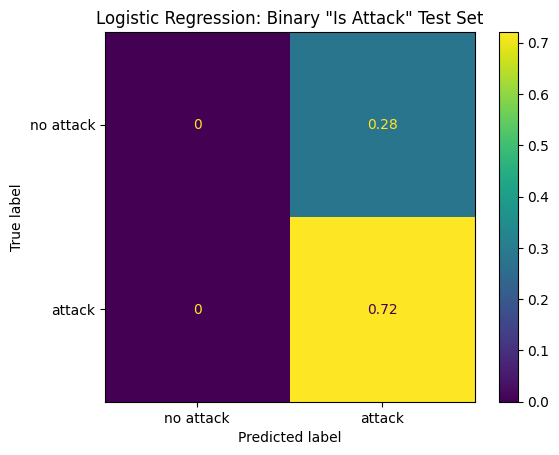

In [11]:
%matplotlib
ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=['no attack','attack'],
        normalize='all',
    )
plt.title('Logistic Regression: Binary "Is Attack" Test Set')
plt.show()

In [12]:
df['is_attack'].value_counts() / df['is_attack'].shape[0]

is_attack
True     0.710196
False    0.289804
Name: count, dtype: float64

In [13]:
print(classification_report(clf.predict(X_test), y_test, target_names=['no_attack','attack']))

              precision    recall  f1-score   support

   no_attack       0.00      0.00      0.00         0
      attack       1.00      0.71      0.83     62702

    accuracy                           0.71     62702
   macro avg       0.50      0.35      0.41     62702
weighted avg       1.00      0.71      0.83     62702



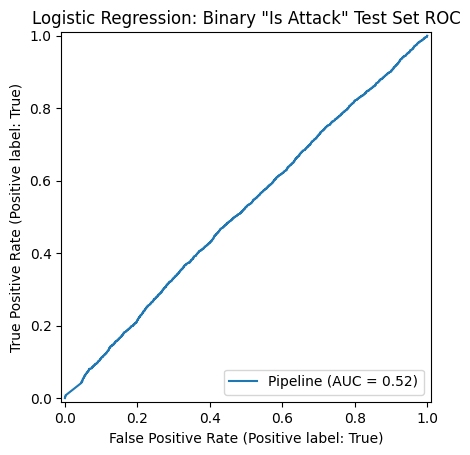

In [14]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title('Logistic Regression: Binary "Is Attack" Test Set ROC')
plt.show()

Apparently it's just guessing "attack" 100% of the time giving us accuracy in proportion to class size.

# GridSearchCV

In [15]:
class_weights = {str(i):j for i, j in zip(np.unique(y_train,return_counts=True)[0],np.unique(y_train,return_counts=True)[1]/y_train.shape[0])}

param_grid = {  'class_weight': [None, 'balanced', class_weights],
                'penalty': ['l1','l2'],
                'C': [0.1, 0.5, 1.0],
}

In [16]:
grid_clf = Pipeline([('preprocessor',preprocessor), 
               ('gridsearch', GridSearchCV(LogisticRegression(random_state=random_seed),
                    param_grid=param_grid,
                    cv=timecv,
                    refit=True))
               ])

grid_clf.fit(X_train, y_train)
print(grid_clf.score(X_train, y_train))
print(grid_clf.score(X_test, y_test))

0.7073777550955312
0.7203189792663477


In [17]:
grid_clf['gridsearch'].best_params_

{'C': 0.1, 'class_weight': None, 'penalty': 'l2'}

Identical result/params to LogRegCV.

In [25]:
for i,j in zip(grid_clf[:-1].get_feature_names_out(), grid_clf['gridsearch'].best_estimator_.coef_.ravel()):
    print(i, 'coefficient:', j)

scaler__R1_Phase_A_power_wave coefficient: -0.9775570408747203
scaler__R1_Phase_A_pos_neg_zero_power_wave coefficient: 0.8876980033583324
scaler__R1_Phase_B_power_wave coefficient: -0.05241323057080443
scaler__R1_Phase_B_pos_neg_zero_power_wave coefficient: -0.23416131210629082
scaler__R1_Phase_C_power_wave coefficient: -0.08232643044574621
scaler__R1_Phase_C_pos_neg_zero_power_wave coefficient: 0.12490915829436375


It's giving the highest 'feature importance' to pos_neg_zero_power which has no variance, hence always predicting 'attack'.